## Contents
- #### [1.Importing Libraries](#1)
- #### [2.Dataset Managament](#2)
    - #### [2.1.Downloading , Extracting and Spliting Dataset](#2.1)
    - #### [2.2.Pytorch Dataset](#2.2)
    - #### [2.3.Pytorch DataLoaders](#2.3)
- #### [3.Initializing pre-trained model](#3)
- #### [4.Training](#4)
- #### [5.Plotting Graphs](#5)
    - #### [5.1.Plotting Loss vs Epoch](#5.1)
    - #### [5.2.Plotting Accuracy vs Epoch](#5.2)
- #### [6.Loading and Testing](#6)

### 1.Importing Libraries <a class="anchor" id="1"></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import wget
import tarfile
import os
import math
import torchvision.transforms as T

sns.set_style("darkgrid")

### 2.Dataset Managament <a class="anchor" id="2"></a>

#### 1.Downloading , Extracting and Spliting Dataset <a class="anchor" id="2.1"></a>

In [2]:
zip_file_url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
#check if the zipfile already exists

if "images.tar" not in os.listdir() :
    wget.download('http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar')
    
#check if the zip file is extracted

if len(os.listdir("data/"))== 0:

    # open file
    file = tarfile.open('images.tar')
  
    # extracting file
    file.extractall('data/')
    print("Extraction completed")
    file.close()
     
    # creating train , test and validation folders
    path = "data/"
    classes = os.listdir(path+'/images')
    os.mkdir("data/train")
    os.mkdir("data/test")
    os.mkdir("data/validation")
            
    for i in classes:
        os.mkdir('data/train/'+i)
        os.mkdir('data/test/'+i)
        os.mkdir('data/validation/'+i)
    
    # (class_n , images_name) storing all the image name/location
    images_path = []
    for i in classes:
        temp = []
        for j in os.listdir(path+'images/'+i+'/'):
            temp.append(j)
        images_path.append(temp)
    
    # splitting train , test and validation images for each classes
    
    train = 0.9
    test = 0.075
    validatiation = 0.025

    train_img_path = []
    test_img_path = []
    validation_img_path = []

    for i in images_path:
        n = len(i)
        train_n = int(train*n)
        test_n = int(test*n)
        validation_n = n - train_n - test_n
    
        train_img_path.append(i[:train_n])
        test_img_path.append(i[train_n:test_n+train_n])
        validation_img_path.append(i[train_n+test_n:])
    
    # Moving corresponding images to the train , test and validation folders

    for i,class_name in zip(train_img_path,classes):
        for j in i:
            os.rename(path+"Images/"+class_name+"/"+j, path+"train/"+class_name+"/"+j)
        
    for i,class_name in zip(test_img_path,classes):
        for j in i:
            os.rename(path+"Images/"+class_name+"/"+j, path+"test/"+class_name+"/"+j)
        
    for i,class_name in zip(validation_img_path,classes):
        for j in i:
            os.rename(path+"Images/"+class_name+"/"+j, path+"validation/"+class_name+"/"+j)
            

#### 2.Pytorch Dataset <a class="anchor" id="2.2"></a>

In [3]:
class Dataset(Dataset):
    def __init__(self , type = 'train' , transform = 'T.Resize((256,256))'):
        self.x = []
        self.y = []
        self.transform = transform
        self.n_classes = len(os.listdir('data/train/'))
        if type == 'train':
            path = 'data/train/'
            classes = os.listdir(path)
            for i in range(len(classes)):
                for j in os.listdir(path+classes[i]):
                    self.x.append(path+classes[i]+'/'+j)
                    self.y.append(i)

        if type == 'test':
            path = 'data/test/'
            classes = os.listdir(path)
            for i in range(len(classes)):
                for j in os.listdir(path+classes[i]):
                    self.x.append(path+classes[i]+'/'+j)
                    self.y.append(i)
                    
        if type == 'validation':
            path = 'data/validation/'
            classes = os.listdir(path)
            for i in range(len(classes)):
                for j in os.listdir(path+classes[i]):
                    self.x.append(path+classes[i]+'/'+j)
                    self.y.append(i)
                    
        self.len = len(self.x)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,i): # Returning ith image and corresponding label
        image = self.transform(Image.fromarray(np.asarray(Image.open(self.x[i]))[:,:,:3]))
        x = torch.FloatTensor(np.asarray(image))
        return x,torch.LongTensor([self.y[i]])
    


#### 3.Pytorch DataLoaders <a class="anchor" id="2.3"></a>

In [4]:
batch_size = 16
classes = os.listdir('data/train/')
n_classes = len(classes)

transforms_train = T.Compose([
        T.Resize((224,224)),
        T.RandomRotation(degrees=30), #Data Augmentation to prevent overfitting
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transforms_test = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


train_dataset = Dataset('train',transform =transforms_train )
test_dataset = Dataset('test',transform =transforms_test )
validation_dataset = Dataset('validation',transform =transforms_test )

train_dataloader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True )
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)
validation_dataloader = DataLoader(validation_dataset, batch_size = batch_size)

### 3.Initializing pre-trained model <a class="anchor" id="3"></a>

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True) # Downloading the model
for param in model.parameters():
    param.requires_grad = False                     # Freezing the model parameters that isn't required to be trained
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)

# for name,child in model.named_children():
#     print(name,child)

# class extended_model(nn.Module):
#     def __init__(self,pretrained_model):
#         super().__init__()
#         self.pretrained_model = pretrained_model     #Pretrained models can be extended this way
        
#     def forward(self,x):
#         x = self.pretrained_model(x)
#         x = F.softmax(x)
#         return x

# model = extended_model(model)
model

Using cache found in C:\Users\Gokul adethya/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

### 4.Training <a class="anchor" id="4"></a>

In [6]:
lr = 0.01
epoch = 6
train_dataset_size = train_dataset.__len__()
validation_dataset_size = validation_dataset.__len__()
train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = validation_dataloader.__len__()

device = 'cuda'
model.to(device)
loss_history = [[],[]] #[[train], [validation]]
accuracy_history = [[],[]] #[[train], [validation]]

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(),lr = lr)

In [7]:
for e in range(epoch):
    for batch_idx , (x ,y) in enumerate(train_dataloader):
        model.train() # Setting mode to train
        optimizer.zero_grad()
        x , y = x.to(device) , y.to(device)
        y_pred = model(x).to(device)
        
        # Calculating Loss
        loss = criterion(y_pred,y.reshape(x.shape[0]))
        loss.backward()
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        #Calaculating Accuracy
        correct = 0
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        for i in range(x.shape[0]):
            n = 0
            n = y_pred[i].index(max(y_pred[i]))
            if n == y[i][0]:
                correct = correct + 1
        accuracy_history[0].append((correct/x.shape[0])*100)
        
        if batch_idx % 100 == 0:
            # Printing Log
            print(f'LOSS for EPOCH {e+1} BATCH {batch_idx}/{train_n_minibatches} TRAIN LOSS : {loss_history[0][-1]}',end = ' ')
            print(f'TRAIN ACCURACY : {accuracy_history[0][-1]}',end = ' ')
            with torch.no_grad():
                # Calculating loss and accuracy for validation
                model.eval()
                for _batch_idx_ , (x ,y) in enumerate(validation_dataloader):
                    x , y = x.to(device) , y.to(device)
                    y_pred = model(x).to(device)
                    validation_loss = criterion(y_pred,y.reshape(x.shape[0]))
                    loss_history[1].append(float(validation_loss.detach()))
                    
                    correct = 0
                    y_pred = y_pred.cpu().detach().numpy().tolist()
                    y = y.cpu().detach().numpy().tolist()      
                    for i in range(x.shape[0]):
                        n = 0
                        n = y_pred[i].index(max(y_pred[i]))
                        if n == y[i][0]:
                            correct = correct + 1
                    accuracy_history[1].append((correct/x.shape[0])*100)
                        
                    
                print(f'VALIDATION LOSS : {sum(loss_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
                print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}')
    
    # Saving the model progress
    torch.save(model.state_dict(),'saved_model/wide_resnet50_v1')
    
    #Log for e+1th epoch
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}',end = ' ')
    print(f'TRAIN ACCURACY : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}')
    n_validation_losses = int(train_n_minibatches/100)*validation_n_minibatches
    print(f'VALIDATION LOSS for EPOCH {e+1} : {sum(loss_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses}',end = ' ')
    print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses}')
    print('---------------------------------------------------------------------------------------------')

LOSS for EPOCH 1 BATCH 0/1155 TRAIN LOSS : 4.9413228034973145 TRAIN ACCURACY : 0.0 VALIDATION LOSS : 4.823765218257904 VALIDATION ACCURACY : 1.25
LOSS for EPOCH 1 BATCH 100/1155 TRAIN LOSS : 4.544984340667725 TRAIN ACCURACY : 6.25 VALIDATION LOSS : 4.429252362251281 VALIDATION ACCURACY : 14.84375
LOSS for EPOCH 1 BATCH 200/1155 TRAIN LOSS : 4.374787330627441 TRAIN ACCURACY : 6.25 VALIDATION LOSS : 4.072540128231049 VALIDATION ACCURACY : 26.875
LOSS for EPOCH 1 BATCH 300/1155 TRAIN LOSS : 4.061705112457275 TRAIN ACCURACY : 12.5 VALIDATION LOSS : 3.731694746017456 VALIDATION ACCURACY : 36.5625
LOSS for EPOCH 1 BATCH 400/1155 TRAIN LOSS : 3.850318670272827 TRAIN ACCURACY : 43.75 VALIDATION LOSS : 3.4004035234451293 VALIDATION ACCURACY : 52.03125
LOSS for EPOCH 1 BATCH 500/1155 TRAIN LOSS : 3.2602427005767822 TRAIN ACCURACY : 56.25 VALIDATION LOSS : 3.1177640736103056 VALIDATION ACCURACY : 52.65625
LOSS for EPOCH 1 BATCH 600/1155 TRAIN LOSS : 3.0547163486480713 TRAIN ACCURACY : 62.5 VALIDA

LOSS for EPOCH 4 BATCH 1100/1155 TRAIN LOSS : 1.2348018884658813 TRAIN ACCURACY : 81.25 VALIDATION LOSS : 0.777744361013174 VALIDATION ACCURACY : 80.46875
---------------------------------------EPOCH 4-------------------------------------------
Loss for EPOCH 4  TRAIN LOSS : 1.2578645976590903 TRAIN ACCURACY : 72.63708513708515
VALIDATION LOSS for EPOCH 4 : 0.8320555417713794 VALIDATION ACCURACY : 79.9715909090909
---------------------------------------------------------------------------------------------
LOSS for EPOCH 5 BATCH 0/1155 TRAIN LOSS : 1.1308830976486206 TRAIN ACCURACY : 68.75 VALIDATION LOSS : 0.7656354811042547 VALIDATION ACCURACY : 80.46875
LOSS for EPOCH 5 BATCH 100/1155 TRAIN LOSS : 1.4353030920028687 TRAIN ACCURACY : 62.5 VALIDATION LOSS : 0.7865335967391729 VALIDATION ACCURACY : 79.0625
LOSS for EPOCH 5 BATCH 200/1155 TRAIN LOSS : 1.1915767192840576 TRAIN ACCURACY : 68.75 VALIDATION LOSS : 0.7930111236870289 VALIDATION ACCURACY : 80.78125
LOSS for EPOCH 5 BATCH 300/

### 5.Plotting Graphs<a class="anchor" id="5"></a>

#### 1.Plotting Loss vs Epoch<a class="anchor" id="5.1"></a>

c:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


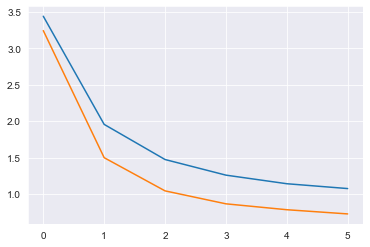

In [8]:
# Plotting Loss per epoch
loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in loss_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    loss_per_epoch[1].append(temp/n_validation_losses)    

sns.lineplot(range(len(loss_per_epoch[0])),loss_per_epoch[0])
sns.lineplot(range(len(loss_per_epoch[1])),loss_per_epoch[1])
plt.show()

#### 2.Plotting Accuracy vs Epoch<a class="anchor" id="5.2"></a>

c:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


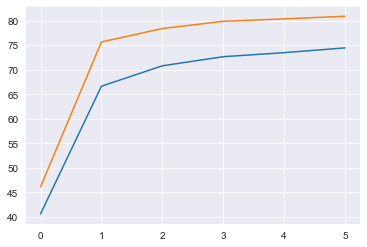

In [9]:
# Plotting Accuracy per epoch
accuracy_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in accuracy_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in accuracy_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    accuracy_per_epoch[1].append(temp/n_validation_losses)    

sns.lineplot(range(len(accuracy_per_epoch[0])),accuracy_per_epoch[0])
sns.lineplot(range(len(accuracy_per_epoch[1])),accuracy_per_epoch[1])
plt.show()

### 6.Loading and Testing<a class="anchor" id="6"></a>

In [10]:
#Loading the saved model
model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
model.load_state_dict(torch.load('saved_model/wide_resnet50_v1', map_location='cpu'))
model.to('cuda')

Using cache found in C:\Users\Gokul adethya/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [11]:
#Displaying the model summary
from torchsummary import summary
summary(model, (3,224,224), batch_size=16 , device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 112, 112]           9,408
       BatchNorm2d-2         [16, 64, 112, 112]             128
              ReLU-3         [16, 64, 112, 112]               0
         MaxPool2d-4           [16, 64, 56, 56]               0
            Conv2d-5          [16, 128, 56, 56]           8,192
       BatchNorm2d-6          [16, 128, 56, 56]             256
              ReLU-7          [16, 128, 56, 56]               0
            Conv2d-8          [16, 128, 56, 56]         147,456
       BatchNorm2d-9          [16, 128, 56, 56]             256
             ReLU-10          [16, 128, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]          32,768
      BatchNorm2d-12          [16, 256, 56, 56]             512
           Conv2d-13          [16, 256, 56, 56]          16,384
      BatchNorm2d-14          [16, 256,

In [12]:
test_loss_history = []
test_accuracy_history = []

In [13]:
#Testing the model on test dataset
model = model.to('cpu')
model.eval()
for _batch_idx_ , (x ,y) in enumerate(test_dataloader):
    y_pred = model(x)
    test_loss = criterion(y_pred,y.reshape(x.shape[0]))
    test_loss_history.append(float(test_loss.detach()))
    correct = 0
    y_pred = y_pred.detach().numpy().tolist()
    y = y.detach().numpy().tolist()      
    for i in range(x.shape[0]):
        n = 0
        n = y_pred[i].index(max(y_pred[i]))
        if n == y[i][0]:
            correct = correct + 1
    test_accuracy_history.append((correct/len(y))*100)
                        
print(f'LOSS : {sum(test_loss_history)/len(test_loss_history)}  ACCURACY : {sum(test_accuracy_history)/len(test_accuracy_history)}')                    

LOSS : 0.6641809101546964  ACCURACY : 82.88978494623656
